In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time
import os
from collections import defaultdict
from copy import deepcopy
import gdown
import json

In [ ]:
# Torch
import urllib
import torch, torch.nn as nn
import torch.nn.functional as F
import torchvision.models
from torchvision import transforms
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## EEG data

Loading the data from the reference [article](https://www.mdpi.com/2227-7390/10/15/2819):

In [ ]:
if not os.path.exists('dataset'):
    !wget --content-disposition 'https://figshare.com/ndownloader/files/35265655' -O 'EEG_dataset.zip'
    !unzip -q 'EEG_dataset.zip'
    ignore_files = ['dataset/Participant 3/Participant 1', 'dataset/Participant 3/Participant 2']
    for path in ignore_files:
        if os.path.exists(path):
            !rm -rf '{path}'

Read the data:

In [ ]:
channels = pd.read_csv('dataset/Channels.dat', header=None, engine='python')
channels = channels[0].apply(lambda x: x.split(' ')[1])
columns = channels.tolist() + ['extra_1', 'extra_2', 'extra_3']
left_channels = []
right_channels = []

In [ ]:
from scipy.signal import butter, filtfilt, sosfiltfilt

def butter_bandpass_filter(data, lowcut, highcut, fs, order=2):
    #nyquist = 0.5 * fs  # Nyquist frequency
    #low = lowcut / nyquist
    #high = highcut / nyquist
    sos = butter(N=order, Wn=[lowcut, highcut], btype='bandpass', fs=fs, output='sos')  # Design the filter
    return sosfiltfilt(sos, data)  # Apply the filter

def filter_eeg_into_bands(df, fs):
    # Define frequency bands
    bands = {
        'delta': (1, 4),
        'theta': (5, 8),
        'alpha': (8, 12),
        'beta': (13, 30),
        'gamma': (31, 45)
    }

    # Initialize dictionary to store filtered data
    filtered_dfs = {}

    #Referencing
    average_signal = df.mean(axis=1)
    df_referenced = df.sub(average_signal, axis=0)

    #Centering
    df_centered = df_referenced - df_referenced.mean(axis=0)

    # Apply bandpass filtering for each frequency band
    for band, (lowcut, highcut) in bands.items():
        filtered_data = butter_bandpass_filter(df_centered.values, lowcut, highcut, fs)
        filtered_df = pd.DataFrame(filtered_data, columns=df_centered.columns)
        filtered_dfs[band] = filtered_df
    #filtered_dfs['raw'] = df
    #filtered_dfs['full_centered'] = df_centered
    return filtered_dfs

In [ ]:
datasets = defaultdict(lambda: defaultdict(dict))
for root, dirs, files in os.walk('dataset'):
    for file_name in files:
        file_path = os.path.join(root, file_name)
        try:
            if file_name[-4:]=='.dat' and file_name!='Channels.dat':
                folders = file_path.split('/')
                print(file_path)
                ds = folders[2].replace('Cubes for spectra', 'cube').replace('Figs for spectra', 'monalisa').replace('Background', 'bg')
                participant = folders[1].split(' ')[-1]
                f_ops = folders[-1].split('.dat')[0].split('_')
                if len(f_ops)>2:
                    intensity = f'{f_ops[1]}_{f_ops[2]}'
                    I_value = float(f_ops[2])
                else:
                    intensity = None
                #print(f'{ds}, {participant}, {intensity}')
                raw_EEG_df = pd.read_csv(file_path, delimiter='   ', names=columns, header=None, engine='python')
                #Keep only the 31 channels, ignore the last 3 (used for reference calibration)
                raw_EEG_df = raw_EEG_df.drop(['extra_1', 'extra_2', 'extra_3'], axis=1)
                #Filter bands
                filtered_df_dict = filter_eeg_into_bands(raw_EEG_df, fs=250)
                #filtered_df_dict = {'raw': raw_EEG_df}
                if intensity:
                    for band in filtered_df_dict:

                        filtered_df_dict[band]['brightness'] = I_value
                        #Classes from 0 to 9
                        filtered_df_dict[band]['brightness_level'] = int(I_value*10) - 1

                datasets[ds][participant][intensity] = filtered_df_dict

        except Exception as e:
                print(f'Could not read {file_path}: {e}')

dataset/Participant 2/Figs for spectra/Backgr_int_0.6.dat
dataset/Participant 2/Figs for spectra/Backgr_int_0.3.dat
dataset/Participant 2/Figs for spectra/Backgr_int_0.1.dat
dataset/Participant 2/Figs for spectra/Backgr_int_1.dat
dataset/Participant 2/Figs for spectra/Backgr_int_0.9.dat
dataset/Participant 2/Figs for spectra/Backgr_int_0.8.dat
dataset/Participant 2/Figs for spectra/Backgr_int_0.4.dat
dataset/Participant 2/Figs for spectra/Backgr_int_0.2.dat
dataset/Participant 2/Figs for spectra/Backgr_int_0.5.dat
dataset/Participant 2/Figs for spectra/Backgr_int_0.7.dat
dataset/Participant 2/Cubes for spectra/Backgr_int_0.2_type_0.4.dat
dataset/Participant 2/Cubes for spectra/Backgr_int_0.4_type_0.4.dat
dataset/Participant 2/Cubes for spectra/Backgr_int_0.7_type_0.4.dat
dataset/Participant 2/Cubes for spectra/Backgr_int_0.8_type_0.4.dat
dataset/Participant 2/Cubes for spectra/Backgr_int_0.1_type_0.4.dat
dataset/Participant 2/Cubes for spectra/Backgr_int_0.6_type_0.4.dat
dataset/Partic

In [ ]:
#datasets['cube']['2']['int_0.6']['alpha'].head()

In [ ]:
#datasets['cube']['2']['int_0.6']['alpha'].iloc[0]

Now, the 2 separate datasets prepared as torch tensors:

In [ ]:
def prepare_datasets(datasets=datasets):
    contrasts = [0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1]
    bands = {
        'delta': (1, 4),
        'theta': (5, 8),
        'alpha': (8, 12),
        'beta': (13, 30),
        'gamma': (31, 45),
        #'raw': None,
        #'full_centered': None
    }
    X_data = {'cube':{}, 'monalisa':{}}
    y_data = {'cube':{}, 'monalisa':{}}
    trial_sizes =  {'cube':[], 'monalisa':[]}

    for ds_name in ['cube', 'monalisa']:
        for participant in range(1,6):
            for I in contrasts:
                for band in bands:
                    df_ =  datasets[ds_name][str(participant)][f'int_{str(I)}'][band]
                    data_ts = torch.tensor(df_.values).to(device)
                    if band not in X_data[ds_name]:
                        X_data[ds_name][band] = data_ts[:, :-2]
                        y_data[ds_name][band] = data_ts[:, -1].to(torch.int64)
                    else:
                        X_data[ds_name][band] = torch.vstack((X_data[ds_name][band], data_ts[:, :-2]))
                        y_data[ds_name][band] = torch.cat((y_data[ds_name][band], data_ts[: ,-1].to(torch.int64)))
                #Add sizes of each experimental data stacked, all bands should have the same n_points for a given experiment
                trial_sizes[ds_name].append(data_ts.shape[0])

    return X_data, y_data, trial_sizes

In [ ]:
X_data, y_data, trial_sizes = prepare_datasets()

One participant data:

In [ ]:
def SingleSubjectData(ds_name, participant):
    contrasts = [0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1]
    bands = {
        'delta': (1, 4),
        'theta': (5, 8),
        'alpha': (8, 12),
        'beta': (13, 30),
        'gamma': (31, 45),
        #'raw': None,
        #'full_centered': None
    }

    X_data_k = {}
    y_data_k = {}
    for I in contrasts:
        for band in bands:
            df_ =  datasets[ds_name][str(participant)][f'int_{str(I)}'][band]
            data_ts = torch.tensor(df_.values).to(device)
            if band not in X_data_k:
                X_data_k[band] = data_ts[:, :-2]
                y_data_k[band] = data_ts[:, -1].to(torch.int64)
            else:
                X_data_k[band] = torch.vstack((X_data_k[band], data_ts[:, :-2]))
                y_data_k[band] = torch.cat((y_data_k[band], data_ts[: ,-1].to(torch.int64)))
    return X_data_k, y_data_k

In [ ]:
#X_data_k, y_data_k = SingleSubjectData(ds_name = 'monalisa', participant = 5)
#X = X_data_k['gamma'].to(torch.float32)
#y = y_data_k['gamma'].to(torch.float32)

Shuffling on batch level to keep the temporal order of each data intact:

In [ ]:
def shuffle_batches(X, y, sequence_size, trials):
    """
    Divides X and y (numpy arrays) into batches of length batch_size,
    Shuffles the order of the batches while preserving temporal order of EEG temporal points,
    Reassembles the arrays.
    """
    batches_X = []
    batches_y = []
    trial_boundaries = [0]
    S_remainder = 0
    #cumulative sizes of successive trials
    for size in trials:
        trial_boundaries.append(trial_boundaries[-1] + size)

    # Process each trial
    for i in range(len(trial_boundaries) - 1):
        start = trial_boundaries[i]
        end = trial_boundaries[i+1]
        trial_X = X[start:end]
        trial_y = y[start:end]

        n = trial_X.shape[0]
        num_full_batches = n // sequence_size
        remainder = n % sequence_size
        S_remainder += remainder
        # Create full batches from this trial
        for j in range(num_full_batches):
            batch_X = trial_X[j * sequence_size : (j+1) * sequence_size]
            batch_y = trial_y[j * sequence_size : (j+1) * sequence_size]
            batches_X.append(batch_X)
            batches_y.append(batch_y)

        #Add the leftover data from the trial as its own batch (if any)
        #if remainder > 0:
        #    batches_X.append(trial_X[-remainder:])
        #    batches_y.append(trial_y[-remainder:])
        # The remainder is ignored to not mess up the temporal order after shuffling

    # Shuffle the list of batches
    indices = np.arange(len(batches_X))
    np.random.shuffle(indices)
    X_shuffled = np.concatenate([batches_X[i] for i in indices], axis=0)
    y_shuffled = np.concatenate([batches_y[i] for i in indices], axis=0)

    return X_shuffled, y_shuffled, S_remainder

## DL Models

Importing `SHAP` library:

In [ ]:
!pip install shap
import shap

In [ ]:
# Load what is needed
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from torch.amp import GradScaler, autocast
from torch.optim.lr_scheduler import MultiStepLR
from tqdm import tqdm
import time
import seaborn as sns

Define save/load functions to avoid repeated training:

In [ ]:
def save_model(model, model_path):
    torch.save(model.state_dict(), model_path)

In [ ]:
def load_model(model, model_path):
    model_dict = torch.load(model_path, weights_only=True, map_location=torch.device(device))
    model.load_state_dict(model_dict)

Log all session results to collect it easier later:

In [ ]:
ann_results_dict = {'cube':{}, 'monalisa':{}}
rnn_results_dict = {'cube':{}, 'monalisa':{}}

In [ ]:
# Run preliminary cells from here

In [ ]:
#!zip -r results_h_rnn_cube_delta.zip results

### ANN

Splitting data into training and testing:

In [ ]:
dataset = 'cube'
band = 'alpha'
X = X_data[dataset][band].to(torch.float32)
y = y_data[dataset][band].to(torch.float32)
assert len(trial_sizes[dataset]) == 50
assert sum(trial_sizes[dataset]) == X.shape[0]

In [ ]:
# x = batch_size/sr second(s) worth of data, since the sampling rate is sr = 250 Hz
batch_size = 100

# Shuffle at the batch level to mix the temporal segments while keeping order within each batch
X_shuffled, y_shuffled, S_remainder = shuffle_batches(X.cpu().numpy(), y.cpu().numpy(), batch_size, trials = trial_sizes[dataset])

# Split the shuffled data into training (80%), validation (10%), and test (10%) sets
# Important: shuffle option must stay false, since we dont want temporal points-level shuffling
# Total data size after shuffling and trimming for batch of size 100: 750000, exactly 15000 per trial (50 trials)
# With a batch_size of 100, the split 80-10-10 will give only multiples of 100
total_batch_number = X_shuffled.shape[0]//batch_size
val_test_size = (total_batch_number//5)*batch_size
test_size = ((val_test_size//batch_size)//2)*batch_size
X_train, X_temp, y_train, y_temp = train_test_split(X_shuffled, y_shuffled, test_size=val_test_size, random_state=42, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_size, random_state=42, shuffle=False)

# Make tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val_tensor   = torch.tensor(X_val, dtype=torch.float32).to(device)
X_test_tensor  = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.int64).to(device)
y_val_tensor   = torch.tensor(y_val, dtype=torch.int64).to(device)
y_test_tensor  = torch.tensor(y_test, dtype=torch.int64).to(device)

# Make dataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)

# Make data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
#Simple tests to check if the Shuffling is done right
assert X_shuffled.shape[0]+S_remainder == X.shape[0]
assert y_shuffled.shape[0]+S_remainder == y.shape[0]
#Check the splitting
assert X_shuffled.shape[0] == X_train_tensor.shape[0] + X_val_tensor.shape[0] + X_test_tensor.shape[0]
assert y_shuffled.shape[0] == y_train_tensor.shape[0] + y_val_tensor.shape[0] + y_test_tensor.shape[0]
assert X_train_tensor.shape[0] % batch_size == X_val_tensor.shape[0] % batch_size == X_test_tensor.shape[0] % batch_size == 0

In [ ]:
X_test_tensor.shape

torch.Size([77800, 31])

Let's start with the ANN model as defined in the reference [article](https://www.mdpi.com/2227-7390/10/15/2819):

In [ ]:
class EEG_ANN(nn.Module):
    def __init__(self, input_shape, n_classes):
        super(EEG_ANN, self).__init__()
        batch_size, num_channels = input_shape

        # Hidden layers
        self.fc1 = nn.Linear(num_channels, 2500) # Input to first hidden layer
        self.fc2 = nn.Linear(2500, 1000)         # Second hidden layer
        self.fc3 = nn.Linear(1000, 500)          # Third hidden layer
        self.fc4 = nn.Linear(500, 200)           # Fourth hidden layer
        self.fc5 = nn.Linear(200, 100)           # Fifth hidden layer
        self.fc6 = nn.Linear(100, 50)            # Sixth hidden layer
        self.fc7 = nn.Linear(50, 25)             # Seventh hidden layer
        self.fc8 = nn.Linear(25, 15)             # Eighth hidden layer

        # Output layer
        self.fc_out = nn.Linear(15, n_classes)   # Output layer

        # Activation functions
        self.tanh = nn.Tanh()                  # Tanh activation
        self.softmax = nn.Softmax(dim=1)       # Softmax activation

    def forward(self, x):
        # Flatten the input tensor
        #x = torch.flatten(x, start_dim=1)  # Shape: (batch, sequence_length*num_channels)

        # Pass through hidden layers with tanh activation
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.tanh(self.fc3(x))
        x = self.tanh(self.fc4(x))
        x = self.tanh(self.fc5(x))
        x = self.tanh(self.fc6(x))
        x = self.tanh(self.fc7(x))
        x = self.tanh(self.fc8(x))

        # Output layer with softmax activation
        x = self.fc_out(x)

        return x

In [ ]:
n_channels = 31
n_classes = 10
ANN_model = EEG_ANN((batch_size, n_channels), n_classes).to(device)

In [ ]:
loss_fct = nn.CrossEntropyLoss()
#scaler = GradScaler()
optimizer = torch.optim.Adagrad(ANN_model.parameters(), lr=5e-3)

In [ ]:
epochs = 50
loss_threshold = 1e-3
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
duration = time.time()

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    #Training
    ANN_model.train()
    epoch_train_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    progress_bar = tqdm(train_loader, desc="Training")
    for X_batch, y_batch in progress_bar:
        optimizer.zero_grad()

        # Forward pass with mixed precision
        #with autocast(device_type=torch.device(device).type, dtype=torch.float16):
        if True:
            output = ANN_model(X_batch)
            loss = loss_fct(output, y_batch)
            epoch_train_loss += loss.item()

            #Calculate accuracy
            _, predicted = torch.max(output, 1)
            correct_predictions += (predicted == y_batch).sum().item()
            total_predictions += y_batch.size(0)


        # Backward pass and optimization
        #scaler.scale(loss).backward()
        #nn.utils.clip_grad_norm_(ANN_model.parameters(), max_norm=1.0)
        #scaler.step(optimizer)
        #scaler.update()

        loss.backward()
        #nn.utils.clip_grad_norm_(ANN_model.parameters(), max_norm=1.0)
        optimizer.step()

        #Free up memory
        #torch.cuda.empty_cache()

        #Update progress bar
        progress_bar.set_postfix(loss=loss.item())
    # Training stats
    train_loss = epoch_train_loss/len(train_loader)
    accuracy = 100*correct_predictions/total_predictions
    train_losses.append(train_loss)
    train_accuracies.append(accuracy)
    print(f'Average epoch training loss: {train_loss:.3f}')
    print(f'Training accuracy: {accuracy:.3f}%')

    #Validation
    ANN_model.eval()
    epoch_val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    progress_bar = tqdm(val_loader, desc="Validation")
    for X_batch, y_batch in progress_bar:
        #with autocast(device_type=torch.device(device).type, dtype=torch.float16):
        if True:
            output = ANN_model(X_batch)
            loss = loss_fct(output, y_batch)
            epoch_val_loss += loss.item()

            #Calculate accuracy
            _, predicted = torch.max(output, 1)
            correct_predictions += (predicted == y_batch).sum().item()
            total_predictions += y_batch.size(0)

        # Update progress bar
        progress_bar.set_postfix(val_loss=loss.item())
    # Validation stats
    val_loss = epoch_val_loss/len(val_loader)
    accuracy = 100*correct_predictions/total_predictions
    val_losses.append(val_loss)
    val_accuracies.append(accuracy)
    print(f'Average epoch validation loss: {val_loss:.3f}')
    print(f'Validation accuracy: {accuracy:.3f}% \n')


    #Loss condition
    if val_loss <= loss_threshold or accuracy > 99.9:
        break


duration = time.time() - duration
print(f'ANN training and validation time (s): {duration:.1f}')

Epoch 1/50


Training: 100%|██████████| 6232/6232 [00:35<00:00, 177.56it/s, loss=2.25]


Average epoch training loss: 2.280
Training accuracy: 13.324%


Validation: 100%|██████████| 779/779 [00:02<00:00, 327.49it/s, val_loss=2.14]


Average epoch validation loss: 2.276
Validation accuracy: 12.910% 

Epoch 2/50


Training: 100%|██████████| 6232/6232 [00:35<00:00, 177.79it/s, loss=2.24]


Average epoch training loss: 2.238
Training accuracy: 15.978%


Validation: 100%|██████████| 779/779 [00:02<00:00, 337.11it/s, val_loss=2.22]


Average epoch validation loss: 2.260
Validation accuracy: 15.082% 

Epoch 3/50


Training: 100%|██████████| 6232/6232 [00:35<00:00, 177.06it/s, loss=2.2]


Average epoch training loss: 2.176
Training accuracy: 20.229%


Validation: 100%|██████████| 779/779 [00:02<00:00, 323.63it/s, val_loss=2.18]


Average epoch validation loss: 2.214
Validation accuracy: 18.375% 

Epoch 4/50


Training: 100%|██████████| 6232/6232 [00:34<00:00, 179.29it/s, loss=2.12]


Average epoch training loss: 2.079
Training accuracy: 25.960%


Validation: 100%|██████████| 779/779 [00:02<00:00, 324.01it/s, val_loss=2.08]


Average epoch validation loss: 2.116
Validation accuracy: 24.246% 

Epoch 5/50


Training: 100%|██████████| 6232/6232 [00:34<00:00, 179.00it/s, loss=1.82]


Average epoch training loss: 1.977
Training accuracy: 31.296%


Validation: 100%|██████████| 779/779 [00:02<00:00, 331.64it/s, val_loss=2.17]


Average epoch validation loss: 2.063
Validation accuracy: 27.083% 

Epoch 6/50


Training: 100%|██████████| 6232/6232 [00:34<00:00, 178.38it/s, loss=1.9]


Average epoch training loss: 1.887
Training accuracy: 35.263%


Validation: 100%|██████████| 779/779 [00:02<00:00, 303.88it/s, val_loss=2.45]


Average epoch validation loss: 1.997
Validation accuracy: 30.368% 

Epoch 7/50


Training: 100%|██████████| 6232/6232 [00:34<00:00, 178.59it/s, loss=1.8]


Average epoch training loss: 1.801
Training accuracy: 38.880%


Validation: 100%|██████████| 779/779 [00:02<00:00, 275.91it/s, val_loss=2.2]


Average epoch validation loss: 1.956
Validation accuracy: 32.625% 

Epoch 8/50


Training: 100%|██████████| 6232/6232 [00:35<00:00, 176.33it/s, loss=1.72]


Average epoch training loss: 1.723
Training accuracy: 42.093%


Validation: 100%|██████████| 779/779 [00:02<00:00, 271.04it/s, val_loss=2.2]


Average epoch validation loss: 1.911
Validation accuracy: 35.266% 

Epoch 9/50


Training: 100%|██████████| 6232/6232 [00:35<00:00, 176.97it/s, loss=1.55]


Average epoch training loss: 1.652
Training accuracy: 44.878%


Validation: 100%|██████████| 779/779 [00:02<00:00, 294.47it/s, val_loss=1.94]


Average epoch validation loss: 1.876
Validation accuracy: 37.105% 

Epoch 10/50


Training: 100%|██████████| 6232/6232 [00:35<00:00, 176.30it/s, loss=1.51]


Average epoch training loss: 1.593
Training accuracy: 47.008%


Validation: 100%|██████████| 779/779 [00:02<00:00, 319.87it/s, val_loss=2.03]


Average epoch validation loss: 1.830
Validation accuracy: 39.162% 

Epoch 11/50


Training: 100%|██████████| 6232/6232 [00:35<00:00, 175.89it/s, loss=1.6]


Average epoch training loss: 1.545
Training accuracy: 48.783%


Validation: 100%|██████████| 779/779 [00:02<00:00, 310.89it/s, val_loss=2.19]


Average epoch validation loss: 1.820
Validation accuracy: 39.574% 

Epoch 12/50


Training: 100%|██████████| 6232/6232 [00:35<00:00, 175.98it/s, loss=1.44]


Average epoch training loss: 1.502
Training accuracy: 50.246%


Validation: 100%|██████████| 779/779 [00:02<00:00, 320.53it/s, val_loss=2.14]


Average epoch validation loss: 1.809
Validation accuracy: 40.171% 

Epoch 13/50


Training: 100%|██████████| 6232/6232 [00:35<00:00, 174.87it/s, loss=1.49]


Average epoch training loss: 1.466
Training accuracy: 51.471%


Validation: 100%|██████████| 779/779 [00:02<00:00, 312.64it/s, val_loss=1.98]


Average epoch validation loss: 1.771
Validation accuracy: 41.458% 

Epoch 14/50


Training: 100%|██████████| 6232/6232 [00:35<00:00, 174.68it/s, loss=1.48]


Average epoch training loss: 1.435
Training accuracy: 52.475%


Validation: 100%|██████████| 779/779 [00:02<00:00, 318.24it/s, val_loss=1.96]


Average epoch validation loss: 1.749
Validation accuracy: 42.325% 

Epoch 15/50


Training: 100%|██████████| 6232/6232 [00:35<00:00, 175.30it/s, loss=1.39]


Average epoch training loss: 1.408
Training accuracy: 53.441%


Validation: 100%|██████████| 779/779 [00:02<00:00, 309.66it/s, val_loss=2.62]


Average epoch validation loss: 1.761
Validation accuracy: 42.323% 

Epoch 16/50


Training: 100%|██████████| 6232/6232 [00:35<00:00, 173.27it/s, loss=1.51]


Average epoch training loss: 1.384
Training accuracy: 54.232%


Validation: 100%|██████████| 779/779 [00:02<00:00, 290.71it/s, val_loss=2.5]


Average epoch validation loss: 1.743
Validation accuracy: 42.926% 

Epoch 17/50


Training: 100%|██████████| 6232/6232 [00:35<00:00, 174.43it/s, loss=1.29]


Average epoch training loss: 1.361
Training accuracy: 54.898%


Validation: 100%|██████████| 779/779 [00:02<00:00, 285.65it/s, val_loss=2.56]


Average epoch validation loss: 1.744
Validation accuracy: 42.661% 

Epoch 18/50


Training: 100%|██████████| 6232/6232 [00:35<00:00, 176.15it/s, loss=1.09]


Average epoch training loss: 1.342
Training accuracy: 55.557%


Validation: 100%|██████████| 779/779 [00:02<00:00, 283.77it/s, val_loss=2.19]


Average epoch validation loss: 1.719
Validation accuracy: 44.122% 

Epoch 19/50


Training: 100%|██████████| 6232/6232 [00:35<00:00, 175.01it/s, loss=1.41]


Average epoch training loss: 1.323
Training accuracy: 56.146%


Validation: 100%|██████████| 779/779 [00:02<00:00, 275.84it/s, val_loss=2.03]


Average epoch validation loss: 1.723
Validation accuracy: 44.198% 

Epoch 20/50


Training: 100%|██████████| 6232/6232 [00:35<00:00, 176.64it/s, loss=1.5]


Average epoch training loss: 1.307
Training accuracy: 56.669%


Validation: 100%|██████████| 779/779 [00:02<00:00, 268.96it/s, val_loss=2.44]


Average epoch validation loss: 1.740
Validation accuracy: 43.968% 

Epoch 21/50


Training: 100%|██████████| 6232/6232 [00:35<00:00, 176.62it/s, loss=1.32]


Average epoch training loss: 1.292
Training accuracy: 57.184%


Validation: 100%|██████████| 779/779 [00:02<00:00, 271.09it/s, val_loss=2.29]


Average epoch validation loss: 1.734
Validation accuracy: 44.294% 

Epoch 22/50


Training: 100%|██████████| 6232/6232 [00:35<00:00, 176.03it/s, loss=1.33]


Average epoch training loss: 1.278
Training accuracy: 57.599%


Validation: 100%|██████████| 779/779 [00:02<00:00, 278.71it/s, val_loss=2.14]


Average epoch validation loss: 1.705
Validation accuracy: 44.852% 

Epoch 23/50


Training: 100%|██████████| 6232/6232 [00:35<00:00, 175.13it/s, loss=1.43]


Average epoch training loss: 1.265
Training accuracy: 58.077%


Validation: 100%|██████████| 779/779 [00:02<00:00, 277.56it/s, val_loss=2.34]


Average epoch validation loss: 1.714
Validation accuracy: 44.942% 

Epoch 24/50


Training: 100%|██████████| 6232/6232 [00:37<00:00, 166.90it/s, loss=1.18]


Average epoch training loss: 1.253
Training accuracy: 58.481%


Validation: 100%|██████████| 779/779 [00:02<00:00, 310.11it/s, val_loss=2.42]


Average epoch validation loss: 1.689
Validation accuracy: 45.370% 

Epoch 25/50


Training: 100%|██████████| 6232/6232 [00:35<00:00, 173.55it/s, loss=1.39]


Average epoch training loss: 1.241
Training accuracy: 58.800%


Validation: 100%|██████████| 779/779 [00:02<00:00, 305.40it/s, val_loss=2.19]


Average epoch validation loss: 1.710
Validation accuracy: 45.045% 

Epoch 26/50


Training: 100%|██████████| 6232/6232 [00:36<00:00, 172.39it/s, loss=1.08]


Average epoch training loss: 1.231
Training accuracy: 59.201%


Validation: 100%|██████████| 779/779 [00:02<00:00, 309.73it/s, val_loss=1.79]


Average epoch validation loss: 1.697
Validation accuracy: 45.438% 

Epoch 27/50


Training: 100%|██████████| 6232/6232 [00:35<00:00, 173.17it/s, loss=1.13]


Average epoch training loss: 1.221
Training accuracy: 59.550%


Validation: 100%|██████████| 779/779 [00:02<00:00, 303.00it/s, val_loss=2.1]


Average epoch validation loss: 1.690
Validation accuracy: 46.008% 

Epoch 28/50


Training: 100%|██████████| 6232/6232 [00:36<00:00, 172.43it/s, loss=1.29]


Average epoch training loss: 1.211
Training accuracy: 59.840%


Validation: 100%|██████████| 779/779 [00:02<00:00, 302.95it/s, val_loss=2.27]


Average epoch validation loss: 1.699
Validation accuracy: 45.868% 

Epoch 29/50


Training: 100%|██████████| 6232/6232 [00:36<00:00, 172.35it/s, loss=1.29]


Average epoch training loss: 1.202
Training accuracy: 60.138%


Validation: 100%|██████████| 779/779 [00:02<00:00, 301.52it/s, val_loss=2.53]


Average epoch validation loss: 1.709
Validation accuracy: 45.517% 

Epoch 30/50


Training: 100%|██████████| 6232/6232 [00:36<00:00, 171.56it/s, loss=1.08]


Average epoch training loss: 1.193
Training accuracy: 60.344%


Validation: 100%|██████████| 779/779 [00:02<00:00, 289.08it/s, val_loss=1.94]


Average epoch validation loss: 1.685
Validation accuracy: 46.294% 

Epoch 31/50


Training: 100%|██████████| 6232/6232 [00:36<00:00, 172.24it/s, loss=1.2]


Average epoch training loss: 1.185
Training accuracy: 60.633%


Validation: 100%|██████████| 779/779 [00:02<00:00, 285.42it/s, val_loss=1.93]


Average epoch validation loss: 1.708
Validation accuracy: 45.810% 

Epoch 32/50


Training: 100%|██████████| 6232/6232 [00:36<00:00, 170.85it/s, loss=1]


Average epoch training loss: 1.178
Training accuracy: 60.887%


Validation: 100%|██████████| 779/779 [00:02<00:00, 274.12it/s, val_loss=2]


Average epoch validation loss: 1.692
Validation accuracy: 46.362% 

Epoch 33/50


Training: 100%|██████████| 6232/6232 [00:36<00:00, 170.59it/s, loss=1.01]


Average epoch training loss: 1.170
Training accuracy: 61.153%


Validation: 100%|██████████| 779/779 [00:02<00:00, 273.09it/s, val_loss=2.31]


Average epoch validation loss: 1.717
Validation accuracy: 45.914% 

Epoch 34/50


Training: 100%|██████████| 6232/6232 [00:36<00:00, 171.83it/s, loss=1.04]


Average epoch training loss: 1.163
Training accuracy: 61.391%


Validation: 100%|██████████| 779/779 [00:03<00:00, 253.14it/s, val_loss=2.34]


Average epoch validation loss: 1.723
Validation accuracy: 45.737% 

Epoch 35/50


Training: 100%|██████████| 6232/6232 [00:36<00:00, 170.65it/s, loss=1.28]


Average epoch training loss: 1.156
Training accuracy: 61.610%


Validation: 100%|██████████| 779/779 [00:02<00:00, 270.80it/s, val_loss=2.28]


Average epoch validation loss: 1.692
Validation accuracy: 46.510% 

Epoch 36/50


Training: 100%|██████████| 6232/6232 [00:36<00:00, 169.93it/s, loss=1.17]


Average epoch training loss: 1.149
Training accuracy: 61.793%


Validation: 100%|██████████| 779/779 [00:02<00:00, 276.49it/s, val_loss=2.21]


Average epoch validation loss: 1.700
Validation accuracy: 46.393% 

Epoch 37/50


Training: 100%|██████████| 6232/6232 [00:36<00:00, 168.64it/s, loss=1.19]


Average epoch training loss: 1.142
Training accuracy: 62.031%


Validation: 100%|██████████| 779/779 [00:02<00:00, 288.77it/s, val_loss=2.11]


Average epoch validation loss: 1.710
Validation accuracy: 46.255% 

Epoch 38/50


Training: 100%|██████████| 6232/6232 [00:37<00:00, 168.01it/s, loss=1.1]


Average epoch training loss: 1.136
Training accuracy: 62.243%


Validation: 100%|██████████| 779/779 [00:02<00:00, 293.38it/s, val_loss=2.5]


Average epoch validation loss: 1.717
Validation accuracy: 46.284% 

Epoch 39/50


Training: 100%|██████████| 6232/6232 [00:37<00:00, 167.22it/s, loss=1.03]


Average epoch training loss: 1.130
Training accuracy: 62.426%


Validation: 100%|██████████| 779/779 [00:02<00:00, 299.26it/s, val_loss=2.24]


Average epoch validation loss: 1.713
Validation accuracy: 46.416% 

Epoch 40/50


Training: 100%|██████████| 6232/6232 [00:37<00:00, 165.30it/s, loss=1.33]


Average epoch training loss: 1.125
Training accuracy: 62.551%


Validation: 100%|██████████| 779/779 [00:02<00:00, 284.57it/s, val_loss=2.35]


Average epoch validation loss: 1.714
Validation accuracy: 46.652% 

Epoch 41/50


Training: 100%|██████████| 6232/6232 [00:37<00:00, 164.95it/s, loss=1.25]


Average epoch training loss: 1.118
Training accuracy: 62.805%


Validation: 100%|██████████| 779/779 [00:02<00:00, 291.75it/s, val_loss=2.52]


Average epoch validation loss: 1.713
Validation accuracy: 46.502% 

Epoch 42/50


Training: 100%|██████████| 6232/6232 [00:37<00:00, 167.82it/s, loss=1.2]


Average epoch training loss: 1.113
Training accuracy: 62.994%


Validation: 100%|██████████| 779/779 [00:02<00:00, 291.15it/s, val_loss=2.26]


Average epoch validation loss: 1.711
Validation accuracy: 46.456% 

Epoch 43/50


Training: 100%|██████████| 6232/6232 [00:37<00:00, 165.49it/s, loss=1.36]


Average epoch training loss: 1.108
Training accuracy: 63.121%


Validation: 100%|██████████| 779/779 [00:02<00:00, 298.58it/s, val_loss=2.12]


Average epoch validation loss: 1.707
Validation accuracy: 46.539% 

Epoch 44/50


Training: 100%|██████████| 6232/6232 [00:37<00:00, 166.40it/s, loss=1.09]


Average epoch training loss: 1.103
Training accuracy: 63.330%


Validation: 100%|██████████| 779/779 [00:02<00:00, 293.00it/s, val_loss=2.36]


Average epoch validation loss: 1.715
Validation accuracy: 46.589% 

Epoch 45/50


Training: 100%|██████████| 6232/6232 [00:37<00:00, 165.22it/s, loss=1.33]


Average epoch training loss: 1.098
Training accuracy: 63.443%


Validation: 100%|██████████| 779/779 [00:02<00:00, 295.66it/s, val_loss=2.15]


Average epoch validation loss: 1.709
Validation accuracy: 46.890% 

Epoch 46/50


Training: 100%|██████████| 6232/6232 [00:37<00:00, 166.39it/s, loss=1.12]


Average epoch training loss: 1.093
Training accuracy: 63.623%


Validation: 100%|██████████| 779/779 [00:02<00:00, 290.78it/s, val_loss=2.04]


Average epoch validation loss: 1.714
Validation accuracy: 46.782% 

Epoch 47/50


Training: 100%|██████████| 6232/6232 [00:37<00:00, 164.11it/s, loss=1.25]


Average epoch training loss: 1.088
Training accuracy: 63.809%


Validation: 100%|██████████| 779/779 [00:02<00:00, 272.41it/s, val_loss=2.24]


Average epoch validation loss: 1.703
Validation accuracy: 47.027% 

Epoch 48/50


Training: 100%|██████████| 6232/6232 [00:37<00:00, 164.56it/s, loss=1.33]


Average epoch training loss: 1.083
Training accuracy: 63.954%


Validation: 100%|██████████| 779/779 [00:02<00:00, 278.43it/s, val_loss=2.09]


Average epoch validation loss: 1.726
Validation accuracy: 46.597% 

Epoch 49/50


Training: 100%|██████████| 6232/6232 [00:37<00:00, 164.38it/s, loss=1.09]


Average epoch training loss: 1.078
Training accuracy: 64.093%


Validation: 100%|██████████| 779/779 [00:02<00:00, 262.49it/s, val_loss=1.88]


Average epoch validation loss: 1.716
Validation accuracy: 46.720% 

Epoch 50/50


Training: 100%|██████████| 6232/6232 [00:38<00:00, 161.99it/s, loss=1.02]


Average epoch training loss: 1.074
Training accuracy: 64.224%


Validation: 100%|██████████| 779/779 [00:02<00:00, 287.74it/s, val_loss=2.35]

Average epoch validation loss: 1.705
Validation accuracy: 46.944% 

ANN training and validation time (s): 1945.1


Save and/or load model:

In [ ]:
path = f'results/ann/{dataset}/{band}'
os.makedirs(path, exist_ok=True)
loss_fig_name = f'ann_loss_{dataset}_{band}'
acc_fig_name = f'ann_accuracy_{dataset}_{band}'
cm_fig_name = f'ann_cm_{dataset}_{band}'
log_file_name = f'ann_log_{dataset}_{band}'
shap_fig_ch_importance = f'ann_shap_top10_feature_importance_{dataset}_{band}'
shap_fig_summary = f'ann_shap_class-summary_{dataset}_{band}'

In [ ]:
save = True
load = False
model_name = f"ANN_{dataset}_{band}.pt"
if save:
    save_model(ANN_model, path+'/'+model_name)
if load:
    load_model(ANN_model, path+'/'+model_name)

Plotting the training and validation losses:

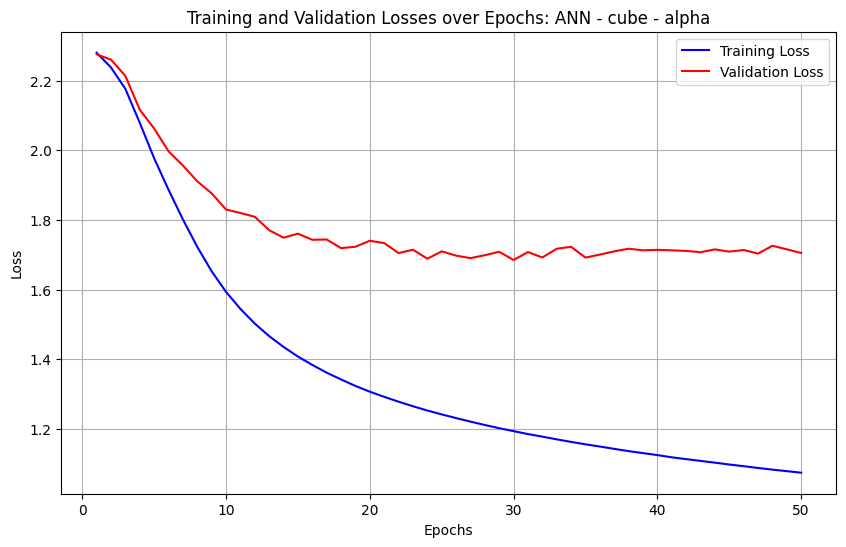

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot([1+i for i in range(epochs)], train_losses, label='Training Loss', color='blue')
plt.plot([1+i for i in range(epochs)], val_losses, label='Validation Loss', color='red')
plt.title(f'Training and Validation Losses over Epochs: ANN - {dataset} - {band}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(f'{path}/{loss_fig_name}.png')
plt.show()

Plotting accuracies:

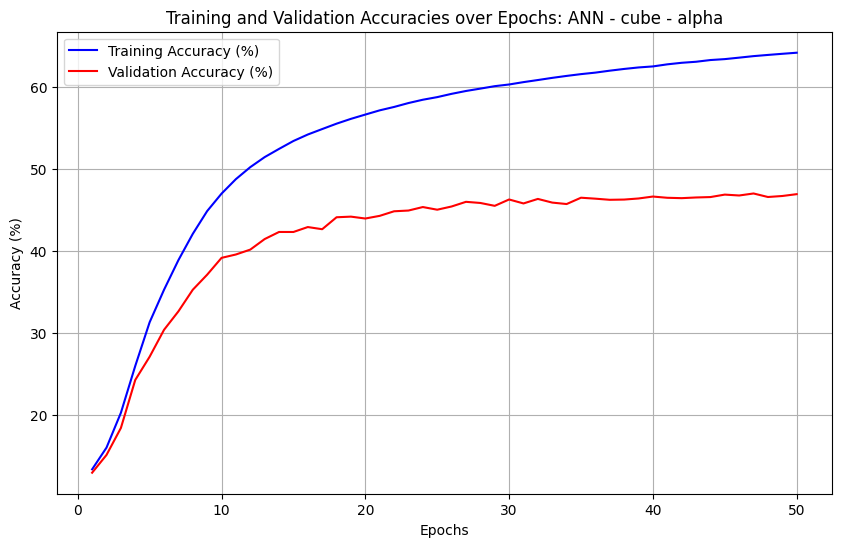

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot([1+i for i in range(epochs)], train_accuracies, label='Training Accuracy (%)', color='blue')
plt.plot([1+i for i in range(epochs)], val_accuracies, label='Validation Accuracy (%)', color='red')
plt.title(f'Training and Validation Accuracies over Epochs: ANN - {dataset} - {band}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.savefig(f'{path}/{acc_fig_name}.png')
plt.show()

In [ ]:
# Testing
ANN_model.eval()
epoch_test_loss = 0.0
correct_predictions = 0
total_predictions = 0
all_preds = []
all_labels = []

progress_bar = tqdm(test_loader, desc="Testing")
for X_batch, y_batch in progress_bar:
    with torch.no_grad():
        output = ANN_model(X_batch)
        loss = loss_fct(output, y_batch)
        epoch_test_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(output, 1)
        correct_predictions += (predicted == y_batch).sum().item()
        total_predictions += y_batch.size(0)

        # Collect predictions and labels for F1 score
        all_preds.extend(predicted.detach().cpu().numpy())
        all_labels.extend(y_batch.detach().cpu().numpy())

    # Update progress bar
    progress_bar.set_postfix(test_loss=loss.item())

# Average test loss
test_loss = epoch_test_loss / len(test_loader)
# Accuracy
test_accuracy = 100 * correct_predictions / total_predictions
# F1 score
test_f1 = 100 * f1_score(all_labels, all_preds, average='macro')
# Recall
test_recall = 100 * recall_score(all_labels, all_preds, average='macro')
# Precision
test_precision = 100 * precision_score(all_labels, all_preds, average='macro')

# Optional: Detailed classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

print(f'\nAverage test loss: {test_loss:.3f}')
print(f'Test accuracy: {test_accuracy:.3f}%')
print(f'Test F1 score: {test_f1:.3f}%')
print(f'Test Recall: {test_recall:.3f}%')
print(f'Test Precision: {test_precision:.3f}%')

Testing: 100%|██████████| 778/778 [00:02<00:00, 319.12it/s, test_loss=4.55]



Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.52      0.49      7200
           1       0.55      0.48      0.52      8100
           2       0.38      0.42      0.40      7300
           3       0.52      0.44      0.47      7800
           4       0.49      0.47      0.48      8600
           5       0.47      0.44      0.46      7300
           6       0.41      0.50      0.45      7600
           7       0.46      0.46      0.46      9000
           8       0.44      0.46      0.45      6600
           9       0.50      0.46      0.48      8300

    accuracy                           0.47     77800
   macro avg       0.47      0.47      0.47     77800
weighted avg       0.47      0.47      0.47     77800


Average test loss: 1.717
Test accuracy: 46.614%
Test F1 score: 46.611%
Test Recall: 46.625%
Test Precision: 46.892%


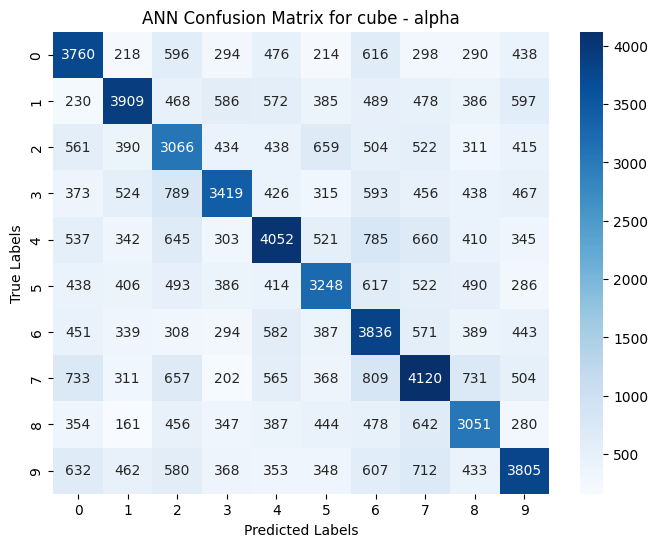

In [ ]:
#torch.argmax(output, dim=1)
cm = confusion_matrix(all_labels, all_preds)
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'ANN Confusion Matrix for {dataset} - {band}')
plt.savefig(f'{path}/{cm_fig_name}.png')
plt.show()

Save a log of the experiment:

In [ ]:
log = f'''
ANN model with Tanh activation
Dataset: {dataset}
Hardware: colab T4 GPU
Frequency channels: {band}
All EEG channels (left and right hemispheres)
Batch size: {batch_size}
Optimiser: Adagrad, 5e-3
epochs: {epochs}
Autocast: off
'''
log_res = ''
log_res += f'\nAverage test loss: {test_loss:.3f}'
log_res += f'\nTest accuracy: {test_accuracy:.3f}%'
log_res += f'\nTest F1 score: {test_f1:.3f}%'
log_res += f'\nTest Recall: {test_recall:.3f}%'
log_res += f'\nTest Precision: {test_precision:.3f}%'
log_res += f'\nTraining time (s): {duration:.1f}'
log += log_res
print(log)
with open(f'{path}/{log_file_name}.txt', 'w') as f:
    f.write(log)


ANN model with Tanh activation
Dataset: cube
Hardware: colab T4 GPU
Frequency channels: alpha
All EEG channels (left and right hemispheres)
Batch size: 100
Optimiser: Adagrad, 5e-3
epochs: 50
Autocast: off

Average test loss: 1.717
Test accuracy: 46.614%
Test F1 score: 46.611%
Test Recall: 46.625%
Test Precision: 46.892%
Training time (s): 1945.1


In [ ]:
ann_results_dict[dataset][band] = log_res[1:].replace('\n', ', ')
with open(f'results/ann/ann_results_dict.json', 'w') as f:
    json.dump(ann_results_dict, f, indent=4)

In [ ]:
ann_results_dict

{'cube': {'alpha': 'Average test loss: 1.717, Test accuracy: 46.614%, Test F1 score: 46.611%, Test Recall: 46.625%, Test Precision: 46.892%, Training time (s): 1945.1'},
 'monalisa': {}}

SHAP explanation:

In [ ]:
def model_predict_ANN(x):
    x_tensor = torch.tensor(x, dtype=torch.float32).to(device)
    with torch.no_grad():
        preds = ANN_model(x_tensor)
    return preds.cpu().numpy()

In [ ]:
torch.cuda.empty_cache()
ANN_model.eval()

# Subset of the training data as background for KernelExplainer
# K: background samples
K = 100
background_data = X_train_tensor[:10000].detach().cpu().numpy()
# Kmeans 10k samples = 100 sequences
kmeans_sklearn = KMeans(n_clusters=K, random_state=42, n_init=10) # Set random_state for reproducibility
kmeans_sklearn.fit(background_data)
background_data_summarised = kmeans_sklearn.cluster_centers_ # Shape: (K, n_channels)


#More background, with less computations
#background_data_summarised = shap.sample(background_data, nsamples=K)

# KernelExplainer instance
explainer = shap.KernelExplainer(model_predict_ANN, background_data_summarised)

# Representative subset of the test set for interpretation
num_test_samples = 50
X_test_samples = X_test_tensor[:num_test_samples].detach().cpu().numpy()
y_test_samples = y_test_tensor[:num_test_samples].detach().cpu().numpy()

# Compute SHAP values on the test set
# For multi-class classification, shap_values is a list (one per class)
shap_values = explainer.shap_values(X_test_samples)

  0%|          | 0/50 [00:00<?, ?it/s]

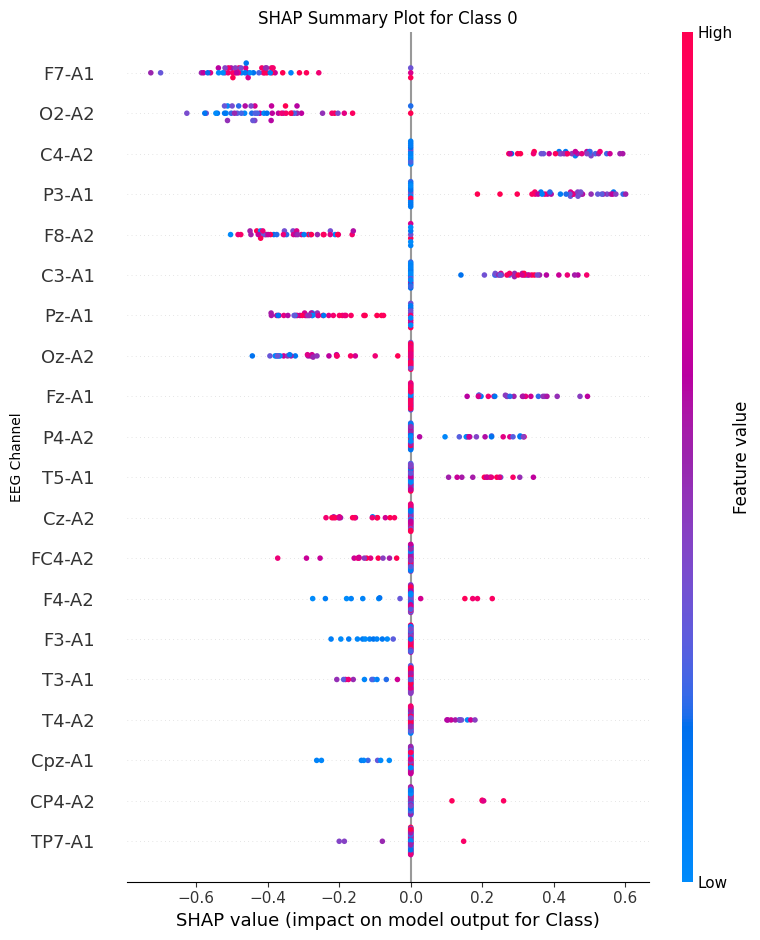

In [ ]:
# 5. Feature Names
feature_names_ann = channels.tolist()
os.makedirs(path+'/shap_summary', exist_ok=True)
# 6. SHAP Summary Plots per Class
for i in range(shap_values.shape[2]):
    fig = plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values[:, :, i], X_test_samples, feature_names=feature_names_ann, show=False)
    plt.title(f"SHAP Summary Plot for Class {i}")
    plt.xlabel("SHAP value (impact on model output for Class)")
    plt.ylabel("EEG Channel")
    plt.tight_layout()
    plt.savefig(f'{path}/shap_summary/{shap_fig_summary}_class{i}.png')
    if i==0:
        plt.show()
    else:
         plt.close(fig)


Top 10 important channels (overall):
Channel T6-A2           | Importance: 0.2164
Channel C4-A2           | Importance: 0.1678
Channel T4-A2           | Importance: 0.1658
Channel Fp1-A1          | Importance: 0.1654
Channel P3-A1           | Importance: 0.1209
Channel Fcz-A1          | Importance: 0.1129
Channel F7-A1           | Importance: 0.1072
Channel Fp2-A2          | Importance: 0.0961
Channel FC3-A1          | Importance: 0.0904
Channel FC4-A2          | Importance: 0.0899


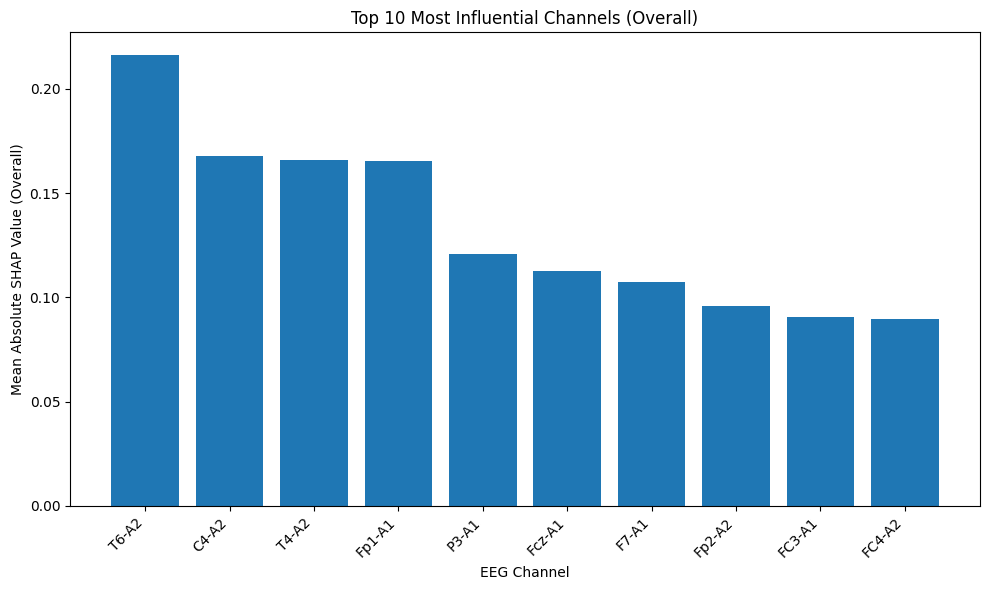

In [ ]:
# 7. Overall Mean Absolute SHAP Value per Channel
mean_abs_shap_per_channel = np.mean(np.abs(shap_values), axis=(0, 2))
sorted_indices = np.argsort(-mean_abs_shap_per_channel)
top_n = 10

print("\nTop 10 important channels (overall):")
for i in range(top_n):
    channel_index = sorted_indices[i]
    channel_name = channels[channel_index]
    importance = mean_abs_shap_per_channel[channel_index]
    print(f"Channel {channel_name:15} | Importance: {importance:.4f}")

# 8. (Optional) Bar Plot of Overall Feature Importance
plt.figure(figsize=(10, 6))
plt.bar(np.array(channels)[sorted_indices[:top_n]], mean_abs_shap_per_channel[sorted_indices[:top_n]])
plt.xlabel("EEG Channel")
plt.ylabel("Mean Absolute SHAP Value (Overall)")
plt.title(f"Top {top_n} Most Influential Channels (Overall)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(f'{path}/{shap_fig_ch_importance}.png')
plt.show()